Loading dataset from: /content/Mall_Customers.csv
Columns found: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Shape: (200, 5)
Using 'Annual Income (k$)' as Income column and 'Spending Score (1-100)' as Spending Score column.
After cleaning, samples: 200


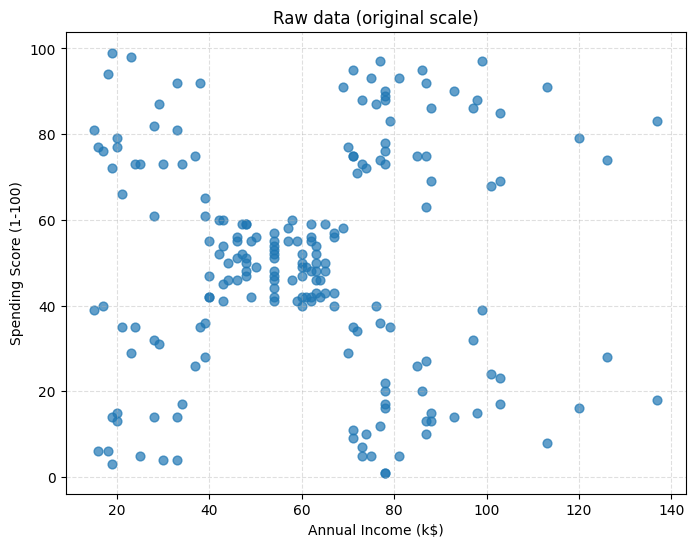

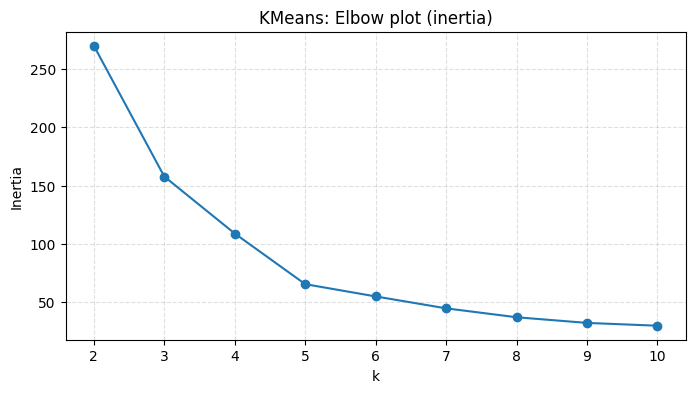

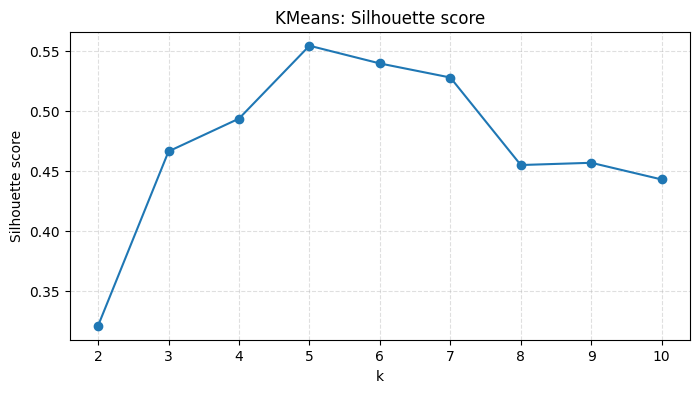

Selected number of clusters for KMeans: k = 5


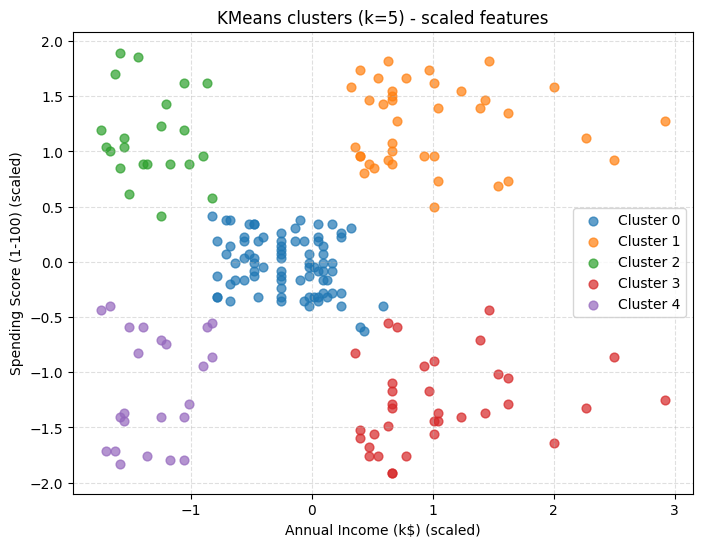

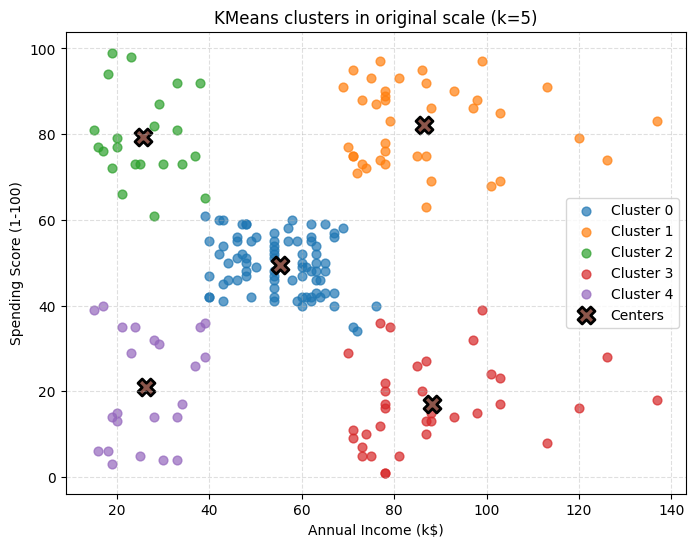


Cluster summary (original scale):
        Annual Income (k$)                    Spending Score (1-100)        \
                     count  mean median   std                  count  mean   
cluster                                                                      
0                       81 55.30  54.00  8.99                     81 49.52   
1                       39 86.54  79.00 16.31                     39 82.13   
2                       22 25.73  24.50  7.57                     22 79.36   
3                       35 88.20  85.00 16.40                     35 17.11   
4                       23 26.30  25.00  7.89                     23 20.91   

                      
        median   std  
cluster               
0        50.00  6.53  
1        83.00  9.36  
2        77.00 10.50  
3        16.00  9.95  
4        17.00 13.02  

DBSCAN eps candidates (on scaled data): ['0.1037', '0.2073', '0.3110', '0.4146']
eps=0.1037 -> clusters=4, noise=166, silhouette (non-noise)=nan
eps=0.2073

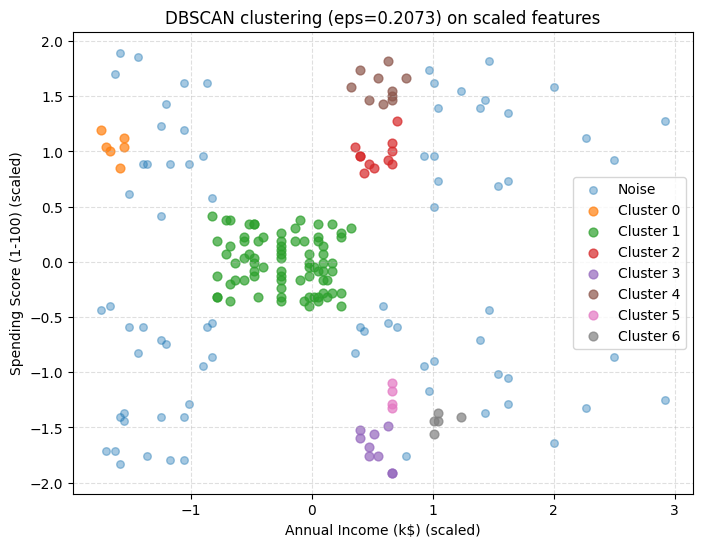


Done. If you want CSV outputs for cluster assignments, uncomment the lines below or write df_clusters to a file.


In [1]:
# Customer Segmentation (KMeans + DBSCAN) - robust script
# Requirements: pandas, numpy, matplotlib, scikit-learn
# Run: pip install pandas numpy matplotlib scikit-learn

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.exceptions import ConvergenceWarning

# suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------- CONFIG ----------
# If you want to force a dataset, change this path
FILE_TRIES = [
    "/content/Mall_Customers.csv",
    "/mnt/data/mall_customers.csv",
    "/mnt/data/Mall_Customers.csv",
    "/mnt/data/mallcustomer.csv",
    "/mnt/data/mall_customers.csv",
    "/mnt/data/covtype.csv",  # fallback (your uploaded file)
    "./covtype.csv",
]
# Choose scaling: 'standard' or 'minmax'
SCALER_TYPE = "standard"
# Range of k to test for KMeans
K_RANGE = range(2, 11)
# ----------------------------

def find_file(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"No dataset found in tried paths: {candidates}")

def infer_columns(df):
    # common names for annual income and spending score in the Mall dataset
    income_candidates = ['Annual Income (k$)', 'Annual Income', 'Income', 'AnnualIncome', 'Income (k$)', 'Annual_Income']
    score_candidates = ['Spending Score (1-100)', 'Spending Score', 'SpendingScore', 'Score', 'Spending_Score']

    income_col = None
    score_col = None

    cols_lower = {c.lower(): c for c in df.columns}

    # Try exact (case-insensitive) matches
    for cand in income_candidates:
        if cand.lower() in cols_lower:
            income_col = cols_lower[cand.lower()]
            break
    for cand in score_candidates:
        if cand.lower() in cols_lower:
            score_col = cols_lower[cand.lower()]
            break

    # If not found, try partial substring matches
    if income_col is None:
        for c in df.columns:
            if 'income' in c.lower() or 'annual' in c.lower():
                income_col = c
                break
    if score_col is None:
        for c in df.columns:
            if 'spend' in c.lower() or 'score' in c.lower() or 'spending' in c.lower():
                score_col = c
                break

    # Last resort: pick first two numeric columns
    if income_col is None or score_col is None:
        numerics = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numerics) >= 2:
            if income_col is None:
                income_col = numerics[0]
            if score_col is None:
                score_col = numerics[1] if numerics[1] != income_col else numerics[0]
        else:
            raise ValueError("Could not infer suitable numeric columns for income and spending score. "
                             "Available columns: " + ", ".join(df.columns))

    return income_col, score_col

def plot_scatter(X, labels=None, title="Scatter", xlabel="Income", ylabel="Spending Score", filename=None):
    plt.figure(figsize=(8,6))
    if labels is None:
        plt.scatter(X[:,0], X[:,1], s=40, alpha=0.7)
    else:
        unique_labels = np.unique(labels)
        for lab in unique_labels:
            mask = (labels == lab)
            plt.scatter(X[mask,0], X[mask,1], s=40, alpha=0.7, label=f"Cluster {lab}")
        plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4)
    if filename:
        plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.show()

def main():
    # 1) Load dataset
    try:
        file_path = find_file(FILE_TRIES)
    except FileNotFoundError as e:
        print(str(e))
        print("If dataset is elsewhere, set FILE_TRIES or change FILE_PATH variable.")
        return

    print(f"Loading dataset from: {file_path}")
    df = pd.read_csv(file_path)
    print("Columns found:", list(df.columns)[:50])
    print("Shape:", df.shape)

    # 2) Infer columns for Income and Spending Score
    try:
        income_col, score_col = infer_columns(df)
    except Exception as ex:
        print("Error inferring columns:", ex)
        return

    print(f"Using '{income_col}' as Income column and '{score_col}' as Spending Score column.")

    # Extract needed data and drop missing values
    data = df[[income_col, score_col]].copy()
    data = data.dropna().reset_index(drop=True)
    # Ensure numeric
    data[income_col] = pd.to_numeric(data[income_col], errors='coerce')
    data[score_col] = pd.to_numeric(data[score_col], errors='coerce')
    data = data.dropna().reset_index(drop=True)
    print("After cleaning, samples:", data.shape[0])

    X_orig = data.values  # keep original for averages
    # 3) Scaling
    if SCALER_TYPE == "standard":
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    X = scaler.fit_transform(X_orig)

    # 4) Visual exploration (raw)
    plot_scatter(X_orig, labels=None, title="Raw data (original scale)",
                 xlabel=income_col, ylabel=score_col)

    # 5) KMeans: elbow (inertia) and silhouette
    inertias = []
    silhouettes = []
    ks = list(K_RANGE)
    for k in ks:
        # KMeans may behave poorly with very small datasets; guard against that
        if k >= X.shape[0]:
            inertias.append(np.nan)
            silhouettes.append(np.nan)
            continue
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        silhouettes.append(sil)

    # Plot elbow
    plt.figure(figsize=(8,4))
    plt.plot(ks, inertias, marker='o')
    plt.title("KMeans: Elbow plot (inertia)")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

    # Plot silhouette
    plt.figure(figsize=(8,4))
    plt.plot(ks, silhouettes, marker='o')
    plt.title("KMeans: Silhouette score")
    plt.xlabel("k")
    plt.ylabel("Silhouette score")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

    # Choose k with best silhouette (fallback to elbow if silhouette is nan)
    best_idx = np.nanargmax(silhouettes)
    best_k = ks[best_idx]
    if np.isnan(silhouettes[best_idx]):
        # fallback: pick k at elbow (smallest inertia elbow heuristic)
        # choose first k where relative drop is small
        rel_drops = np.diff(inertias) / inertias[:-1]
        # If inertias are nan or invalid, default to 5
        try:
            elbow_idx = np.where(np.abs(rel_drops) < 0.15)[0]
            if len(elbow_idx) > 0:
                best_k = ks[elbow_idx[0]+1]
            else:
                best_k = 5 if X.shape[0] > 5 else max(2, X.shape[0]//2)
        except Exception:
            best_k = 5 if X.shape[0] > 5 else max(2, X.shape[0]//2)

    print(f"Selected number of clusters for KMeans: k = {best_k}")

    # Fit final KMeans
    kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20)
    labels_final = kmeans_final.fit_predict(X)
    centers = kmeans_final.cluster_centers_

    # Map centers back to original scale
    centers_orig = scaler.inverse_transform(centers)

    # 6) Plot clusters (scaled input for better separation)
    plot_scatter(X, labels_final, title=f"KMeans clusters (k={best_k}) - scaled features",
                 xlabel=income_col + " (scaled)", ylabel=score_col + " (scaled)")

    # Plot clusters in original scale with centers
    plt.figure(figsize=(8,6))
    unique_labels = np.unique(labels_final)
    for lab in unique_labels:
        mask = (labels_final == lab)
        plt.scatter(X_orig[mask,0], X_orig[mask,1], s=40, alpha=0.7, label=f"Cluster {lab}")
    plt.scatter(centers_orig[:,0], centers_orig[:,1], marker='X', s=150, linewidths=2,
                edgecolors='black', label='Centers')
    plt.title(f"KMeans clusters in original scale (k={best_k})")
    plt.xlabel(income_col)
    plt.ylabel(score_col)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

    # 7) Compute cluster averages (original scale)
    df_clusters = data.copy()
    df_clusters['cluster'] = labels_final
    cluster_summary = df_clusters.groupby('cluster')[[income_col, score_col]].agg(['count','mean','median','std'])
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print("\nCluster summary (original scale):")
    print(cluster_summary)

    # 8) Bonus: try DBSCAN
    # Choose eps relative to data spread (scaled data)
    # heuristic: use median of pairwise distances or a small value like 0.3
    # We'll try eps candidates and show how many clusters (ignoring noise label -1)
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    # Use average of 4th nearest neighbor distances as heuristic
    knn_distances = np.sort(distances[:, -1])
    eps_guess = np.median(knn_distances)
    eps_candidates = [eps_guess*0.5, eps_guess, eps_guess*1.5, eps_guess*2.0]
    print("\nDBSCAN eps candidates (on scaled data):", ["{:.4f}".format(e) for e in eps_candidates])

    for eps in eps_candidates:
        db = DBSCAN(eps=eps, min_samples=5)
        db_labels = db.fit_predict(X)
        n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        n_noise = np.sum(db_labels == -1)
        sil = np.nan
        try:
            if n_clusters_db > 1:
                sil = silhouette_score(X, db_labels[db_labels != -1])
        except Exception:
            sil = np.nan
        print(f"eps={eps:.4f} -> clusters={n_clusters_db}, noise={n_noise}, silhouette (non-noise)={sil}")

    # Fit DBSCAN with the middle candidate (eps_guess)
    db_final = DBSCAN(eps=eps_guess, min_samples=5)
    db_labels_final = db_final.fit_predict(X)

    # Plot DBSCAN result
    plt.figure(figsize=(8,6))
    unique_db = np.unique(db_labels_final)
    for lab in unique_db:
        mask = (db_labels_final == lab)
        if lab == -1:
            # noise
            plt.scatter(X[mask,0], X[mask,1], s=30, alpha=0.4, label='Noise')
        else:
            plt.scatter(X[mask,0], X[mask,1], s=40, alpha=0.7, label=f"Cluster {lab}")
    plt.title(f"DBSCAN clustering (eps={eps_guess:.4f}) on scaled features")
    plt.xlabel(income_col + " (scaled)")
    plt.ylabel(score_col + " (scaled)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

    print("\nDone. If you want CSV outputs for cluster assignments, uncomment the lines below or write df_clusters to a file.")

    # Optional: save cluster assignments
    # df_clusters.to_csv("customer_clusters.csv", index=False)
    # print("Saved cluster assignments to customer_clusters.csv")

if __name__ == "__main__":
    main()
